<a href="https://colab.research.google.com/github/cristianmunoz1/DeepLearning-Project/blob/main/05_torch_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga inicial

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
import os

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jhonatangranda","key":"0f547dc8ab8b2e9acb4f8c16c675367c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nikitarom/planets-dataset
!unzip -q planets-dataset.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/nikitarom/planets-dataset
License(s): DbCL-1.0
 99% 1.48G/1.50G [00:10<00:00, 253MB/s]
100% 1.50G/1.50G [00:10<00:00, 156MB/s]


In [ ]:
import os
print(os.listdir("data"))
print("------------")
print(os.listdir("data/planet/planet"))

['test-jpg-additional', 'planet']
------------
['test-jpg', 'train-jpg', 'sample_submission.csv', 'train_classes.csv']


## Importar Librerias

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import f1_score

En esta celda nos cercioramos del tipo de entorno que esatmos trabajando, para este caso es importante cambiar el entorno de ejecución a GPUs

In [ ]:
# Establecer semillas aleatorias para una reproducibilidad PARCIAL
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#Definimos rutas base
Queremos mostrar las etiquetas, y realizar la respectiva asignación de indice a cada uno de estos

In [ ]:
# Rutas de data
DATA_ROOT = "data/planet/planet"
CSV_PATH = os.path.join(DATA_ROOT, "train_classes.csv")

# Cargar tags
df = pd.read_csv(CSV_PATH)

#Etiquetas unicas
all_labels = []
for label_str in df["tags"]:
    labels = label_str.split()
    all_labels.extend(labels)

unique_labels = sorted(list(set(all_labels)))
label_to_idx = {label: i for i, label in enumerate(unique_labels)}


print(unique_labels)
print(label_to_idx)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']
{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}


En este caso se define una clase para la creación del dataset de manera personalizada, operación que resulta util, cuando se trabajan modelos en Pytorch.
* Recibe los IDs de las imágenes, sus etiquetas y una transformación (augmentación/preprocesado).

* En __getitem__, se abre la imagen correspondiente en formato RGB y aplica las transformaciones.

* Construye un vector multi-label de ceros y pone 1 en las posiciones que correspondan a las etiquetas de esa imagen.

* Retorna (imagen_transformada, vector_de_etiquetas) para que el DataLoader lo use durante el entrenamiento.

Resultado: cada elemento del dataset queda en formato:

`imagen procesada => tensor 3×HxW`

`etiquetas → vector multi-hot (ej: [0,1,0,1,0,...])`

In [ ]:
class PlanetDataset(Dataset):
    def __init__(self, image_ids, labels, transform=None, img_dir=None):
        self.image_ids = image_ids
        self.labels = labels
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Create multi-label target
        target = torch.zeros(len(unique_labels))
        for label in self.labels[idx].split():
            if label in label_to_idx:
                target[label_to_idx[label]] = 1

        return image, target

En este caso se definen 2 pipelines de preprocesamiento:
Se definen primero las transformaciones que se aplicarán a las imágenes. Para el entrenamiento se usa un conjunto de transformaciones con aumentación, donde la imagen se redimensiona a 256 píxeles, luego se aplica un recorte aleatorio a 224×224, se hace un volteo horizontal aleatorio y finalmente se convierte a tensor, se escala a valores entre 0 y 1, y se normaliza usando las medias y desviaciones estándar típicas de ImageNet. Esto introduce variaciones que ayudan al modelo a generalizar mejor.

Para las imágenes de validación o test se define un pipeline más estable, sin aumentación: se redimensionan también a 256 píxeles, se hace un recorte centrado de 224×224 y luego se convierten a tensor y se normalizan igual que antes.

Finalmente se especifican las rutas donde están guardadas las imágenes de entrenamiento y de test. Finalmente, se crea un dataset completo `(full_dataset)` utilizando la clase personalizada `PlanetDataset`, que recibe los nombres de las imágenes y sus etiquetas desde el dataframe, aplica las transformaciones de entrenamiento a cada imagen y construye internamente el vector multi-label correspondiente. Este dataset queda listo para dividirlo en entrenamiento/validación o para ser usado directamente con un `DataLoader`.

In [ ]:
#Definir transformaciones
train_transform = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Definir rutas
train_dir = os.path.join(DATA_ROOT, "train-jpg")
test_dir = os.path.join(DATA_ROOT, "test-jpg")

# Armar dataset
full_dataset = PlanetDataset(
    image_ids=df["image_name"].values,
    labels=df["tags"].values,
    transform=train_transform,
    img_dir=train_dir
)

En este fragmento se divide el dataset completo en dos partes: una para entrenamiento y otra para validación, usando una proporción de 80% y 20% respectivamente. Para ello se calcula el tamaño de cada partición y luego se utiliza random_split, que genera dos subconjuntos tomando muestras aleatorias del dataset original.

 Como ambos subconjuntos provienen del mismo full_dataset, heredarán las mismas transformaciones, pero para la validación no se desea usar aumentación, sino un preprocesamiento fijo y consistente. Por eso, después de hacer la división, se sobrescribe la transformación del dataset de validación asignándole test_transform, garantizando que todas las imágenes del conjunto de validación usen únicamente las transformaciones apropiadas para evaluación.

In [ ]:
# Split into train and validation (80/20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

#  Anular la transformación para el conjunto de datos de validación
val_dataset.dataset.transform = test_transform

En este bloque se prepara el dataset que se usará para hacer inferencias sobre el conjunto de test, cuyas imágenes están en la carpeta test-jpg. Como estas imágenes no tienen etiquetas, primero se obtiene la lista de IDs tomando los nombres de los archivos .jpg y eliminando la extensión. Luego se crea una lista de etiquetas vacías, simplemente para que la clase PlanetDataset mantenga el formato esperado. Finalmente, se construye un dataset de prueba usando esos IDs, las etiquetas vacías y las transformaciones de test, que son las apropiadas para inferencia porque no incluyen aumentación. De esta forma, test_dataset queda listo para utilizarse con un DataLoader y generar predicciones sobre las imágenes del conjunto de test.

In [ ]:
# Para el conjunto de pruebas, utilizaremos la carpeta test-jpg.
# Como no tenemos etiquetas para las pruebas, crearemos un conjunto de datos ficticio para la inferencia.
test_image_ids = [os.path.splitext(f)[0] for f in os.listdir(test_dir) if f.endswith('.jpg')]
test_labels = ["" for _ in test_image_ids]  # Empty labels for test set

test_dataset = PlanetDataset(
    image_ids=test_image_ids,
    labels=test_labels,
    transform=test_transform,
    img_dir=test_dir
)

En este bloque se crean los DataLoaders, que son los encargados de entregar lotes de datos al modelo durante el entrenamiento, validación e inferencia. Se define un batch_size de 32 y se construye un DataLoader para cada uno de los tres subconjuntos. El de entrenamiento (train_loader) mezcla aleatoriamente los datos en cada epoch (shuffle=True) para mejorar la generalización, mientras que los de validación y test no se mezclan, ya que eso no es necesario para evaluar. Todos usan num_workers=4 para cargar imágenes en paralelo y pin_memory=True para acelerar la transferencia de los tensores a la GPU. Con esto, cada DataLoader queda listo para iterar eficientemente sobre sus respectivos datasets durante el entrenamiento y la evaluación del modelo.

In [ ]:
# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4,pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Print dataset sizes
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {len(unique_labels)}")
print(f"Classes: {unique_labels}")


Number of training samples: 32383
Number of validation samples: 8096
Number of test samples: 40669
Number of classes: 17
Classes: ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


Este bloque define dos funciones útiles para visualizar lotes de imágenes. La primera, denormalize, invierte la normalización aplicada previamente para que las imágenes puedan mostrarse con colores naturales; lo que hace es clonar el tensor, multiplicar cada canal por su desviación estándar, sumarle la media correspondiente y asegurarse de que los valores queden entre 0 y 1. La segunda función, plot_batch, toma un DataLoader, extrae un lote de imágenes y etiquetas y muestra algunas de ellas en una cuadrícula. Para cada imagen del lote, se aplica la desnormalización, se reorganizan las dimensiones para que matplotlib pueda interpretarla y luego se obtienen los índices de las clases activas para convertirlos a nombres. Finalmente, se dibuja cada imagen junto con sus etiquetas en el título, organizando la salida en un formato limpio y con un título general encima. Esta función sirve para inspeccionar visualmente si las imágenes y sus etiquetas están siendo cargadas correctamente.

In [ ]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Convertir el tensor de imagen normalizado de nuevo al rango original para su visualización."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)

def plot_batch(dataloader, num_images=6):
    """Extraiga y trace un lote de imágenes con sus etiquetas."""
    # Get a batch from the dataloader
    images, labels = next(iter(dataloader))

    # Convert labels to class names
    batch_size = min(num_images, len(images))
    plt.figure(figsize=(16, 8))

    for i in range(batch_size):
        # Get and denormalize the image
        img = denormalize(images[i])
        img = img.permute(1, 2, 0).cpu().numpy()  # CxHxW to HxWxC

        # Get the labels
        label_indices = torch.where(labels[i] == 1)[0]
        label_names = [list(label_to_idx.keys())[idx] for idx in label_indices]
        label_text = ", ".join(label_names)

        # Plot with larger title font
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"{label_text}", fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Imágenes de muestra con varias etiquetas", y=1.02, fontsize=18)  # Increased from 14 to 18
    plt.show()

Training Data Samples:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


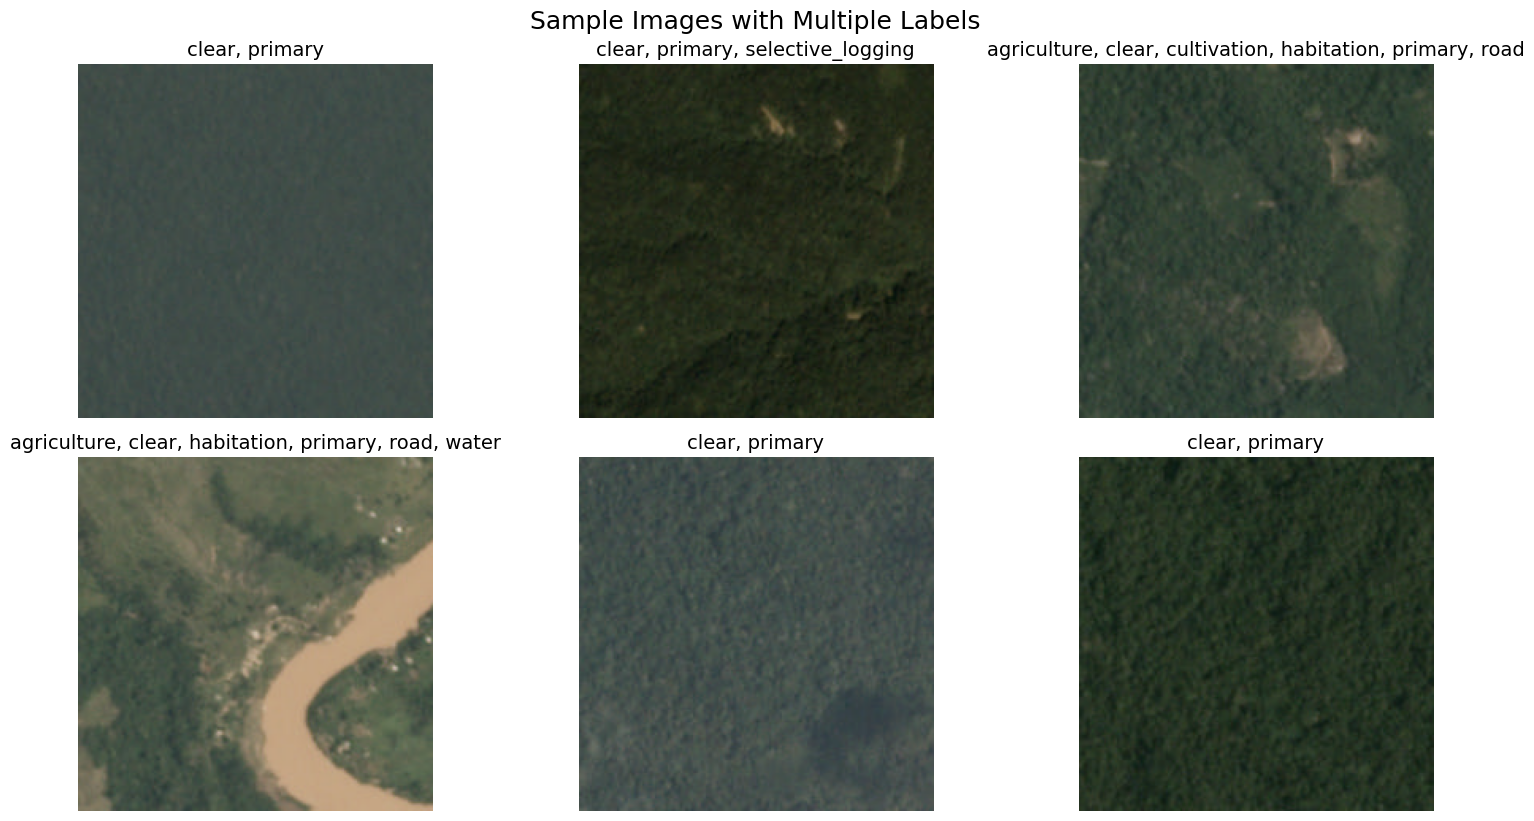

In [ ]:
# Plot samples from training data
print("Training Data Samples:")
plot_batch(train_loader)

Validation Data Samples:


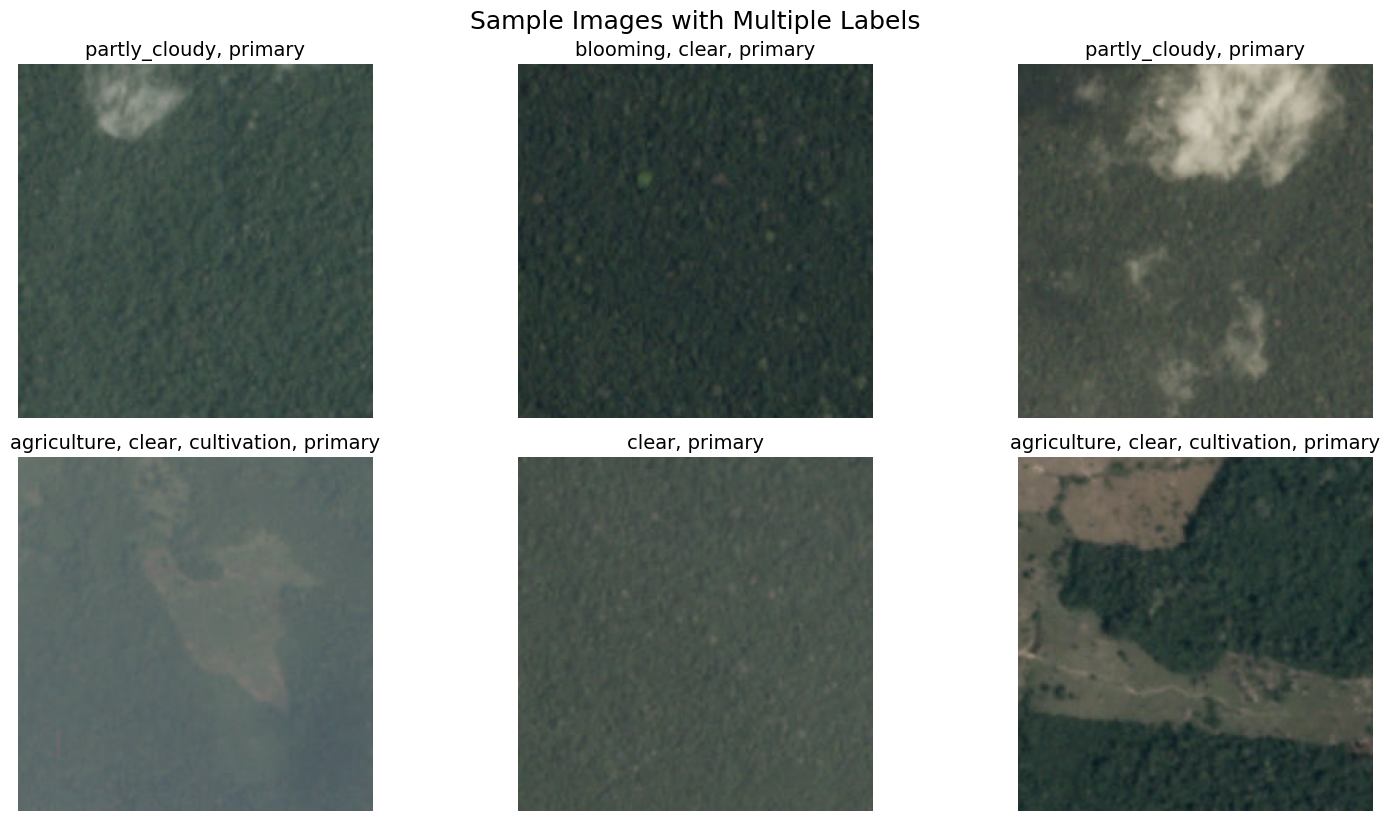

In [ ]:
# Plot samples from validation data
print("Validation Data Samples:")
plot_batch(val_loader)

In [ ]:
# Convert labels to a usable format - extract unique labels
all_labels = []
for label_str in df["tags"]:
    labels = label_str.split()
    all_labels.extend(labels)

unique_labels = sorted(list(set(all_labels)))
label_to_idx = {label: i for i, label in enumerate(unique_labels)}
num_classes = len(unique_labels)
print(f"Number of classes: {num_classes}")
print(f"Classes: {unique_labels}")

Number of classes: 17
Classes: ['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


## Definición de la Arquitectura

En este bloque se define una función para crear el modelo basado en ResNet-18 usando pesos preentrenados en ImageNet. Primero se carga la arquitectura con `models.resnet18(weights='IMAGENET1K_V1')`, lo que permite partir de una red ya entrenada sobre millones de imágenes. Luego se congelan casi todos los parámetros del modelo, dejando únicamente las últimas capas libres para entrenar; esto se hace recorriendo todos los parámetros y desactivando el gradiente excepto en los últimos cuatro, lo que acelera el entrenamiento y evita que la red completa se modifique desde el inicio. Después se reemplaza la última capa totalmente conectada por una nueva capa lineal cuyo número de neuronas coincide con la cantidad de clases del problema, permitiendo que la red produzca un vector de probabilidades multi-label.

In [ ]:
# Create ResNet18 model with pretrained weights
def create_model(num_classes):
    model = models.resnet18(weights='IMAGENET1K_V1')

    # Freeze early layers
    for param in list(model.parameters())[:-4]:
        param.requires_grad = False

    # Replace the final fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

model = create_model(num_classes)
model = model.to(device) #Mover para bloque GPU
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Cambiar función de perdida
Se utiliza `BCEWithLogitsLoss`, que es la pérdida apropiada para problemas multi-label porque trabaja directamente con logits en lugar de probabilidades y evalúa cada clase como un problema binario independiente. Luego se crea el optimizador Adam, que entrenará todos los parámetros configurados como entrenables del modelo, usando una tasa de aprendizaje inicial de 1e-3 y un pequeño weight_decay para ayudar a regularizar. Se establece que el entrenamiento durará 15 épocas. Finalmente, se añade un programador de tasa de aprendizaje mediante `Cosine Annealing`, que reduce progresivamente el learning rate siguiendo una curva coseno y llega hasta 1e-6 en la última época, lo que ayuda a estabilizar el aprendizaje hacia el final y suele mejorar la convergencia. Con estos elementos, el modelo queda listo para iniciar el proceso de entrenamiento.

In [ ]:
# Binary Cross Entropy Loss with Logits
# Esto se aplica cuando la entrada a la pérdida está en el rango entre (-inf, inf)
# Las entradas NO son probabilidades, sino puntuaciones (también conocidas como «logits»).
criterion = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
num_epochs = 15

# Cosine Annealing Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,
    eta_min=1e-6
)

Esta función ejecuta un ciclo completo de entrenamiento para una época. Primero pone el modelo en modo entrenamiento con model.train(), lo que activa capas como dropout o batch norm en su comportamiento adecuado. Luego recorre el DataLoader de entrenamiento lote por lote. Para cada batch, mueve las imágenes y sus etiquetas al dispositivo correspondiente, limpia los gradientes previos del optimizador, pasa los datos por el modelo para obtener los logits y calcula la pérdida comparándolos con las etiquetas reales. Después realiza la retropropagación (loss.backward()) y actualiza los parámetros con optimizer.step(). Si se está usando un scheduler, también se ajusta la tasa de aprendizaje en cada iteración. Durante el proceso, se acumula la pérdida total multiplicada por el tamaño del lote para poder calcular al final la pérdida promedio de la época. Cuando se termina de recorrer todo el conjunto, la función devuelve la pérdida media, que sirve para monitorear cómo evoluciona el entrenamiento.

In [ ]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [ ]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validation"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(val_loader.dataset)
    return epoch_loss

Esta función evalúa el modelo en validación. Desactiva los gradientes, calcula la pérdida para cada batch y acumula todas las etiquetas reales y predichas. Convierte los logits en probabilidades usando sigmoide, aplica un umbral para obtener predicciones binarias y al final calcula el F2-score usando todas las muestras juntas. Devuelve la pérdida promedio de validación y el F2 obtenido.

In [ ]:
# Validation function with F2 tracking
def validate_with_metrics(model, val_loader, criterion, device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Validation", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)

            # For F2 calculation
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()
            all_targets.append(targets.cpu())
            all_predictions.append(preds.cpu())

    epoch_loss = running_loss / len(val_loader.dataset)

    # Calculate F2
    from sklearn.metrics import fbeta_score
    y_true = torch.cat(all_targets).numpy()
    y_pred = torch.cat(all_predictions).numpy()
    f2_score = fbeta_score(y_true, y_pred, beta=2, average='micro', zero_division=0)

    return epoch_loss, f2_score

## Definición función train
Esta función implementa el ciclo completo de entrenamiento. Para cada época entrena el modelo, lo evalúa en validación y registra las métricas: pérdida de entrenamiento, pérdida de validación, F2 y la tasa de aprendizaje. Además, mantiene un registro del mejor F2 obtenido; cuando una época supera ese valor, guarda un checkpoint completo del modelo (pesos, optimizador, scheduler y etiquetas). Al final muestra el tiempo total de entrenamiento, carga el mejor checkpoint y devuelve el modelo con mejor desempeño junto con el historial de métricas.

In [ ]:
# Training loop with F2 tracking
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs, device):
    # For saving the best model
    best_val_f2 = 0.0  #
    checkpoint_path = 'best_model_checkpoint.pth'

    # For tracking metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f2': [],  #
        'learning_rates': []
    }

    # Total time tracking
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train one epoch
        train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)

        # Validate with F2 calculation
        val_loss, val_f2 = validate_with_metrics(model, val_loader, criterion, device)

        # Track current learning rate
        current_lr = scheduler._last_lr[0] if hasattr(scheduler, '_last_lr') else optimizer.param_groups[0]['lr']

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f2'].append(val_f2)
        history['learning_rates'].append(current_lr)

        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F2: {val_f2:.4f}, LR: {current_lr:.6f}")

        #
        if val_f2 > best_val_f2:
            best_val_f2 = val_f2
            # Save the model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'val_loss': val_loss,
                'val_f2': val_f2,  # ← NUEVO
                'train_loss': train_loss,
                'label_to_idx': label_to_idx
            }, checkpoint_path)
            print(f"✓ Model saved at epoch {epoch+1} with F2: {val_f2:.4f}")

        print("-" * 50)

    # Calculate and print total training time
    total_time = time.time() - start_time
    print(f"Total training time: {total_time / 60:.2f} minutes")

    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model loaded from epoch {checkpoint['epoch']+1} with F2: {checkpoint['val_f2']:.4f}")

    return model, history

In [ ]:
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device)


Epoch 1/15


Training: 100%|██████████| 1012/1012 [01:24<00:00, 11.99it/s]


Train Loss: 0.1368, Val Loss: 0.1360, Val F2: 0.8112, LR: 0.000905
✓ Model saved at epoch 1 with F2: 0.8112
--------------------------------------------------
Epoch 2/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:23<00:00, 12.06it/s]


Train Loss: 0.1358, Val Loss: 0.1324, Val F2: 0.8150, LR: 0.000750
✓ Model saved at epoch 2 with F2: 0.8150
--------------------------------------------------
Epoch 3/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:25<00:00, 11.87it/s]


Train Loss: 0.1360, Val Loss: 0.1326, Val F2: 0.8157, LR: 0.000044
✓ Model saved at epoch 3 with F2: 0.8157
--------------------------------------------------
Epoch 4/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:25<00:00, 11.84it/s]


Train Loss: 0.1349, Val Loss: 0.1338, Val F2: 0.8260, LR: 0.000346
✓ Model saved at epoch 4 with F2: 0.8260
--------------------------------------------------
Epoch 5/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:25<00:00, 11.84it/s]


Train Loss: 0.1348, Val Loss: 0.1380, Val F2: 0.8314, LR: 0.000989
✓ Model saved at epoch 5 with F2: 0.8314
--------------------------------------------------
Epoch 6/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:22<00:00, 12.25it/s]


Train Loss: 0.1341, Val Loss: 0.1327, Val F2: 0.8089, LR: 0.000553
--------------------------------------------------
Epoch 7/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:28<00:00, 11.43it/s]


Train Loss: 0.1338, Val Loss: 0.1351, Val F2: 0.8108, LR: 0.000001
--------------------------------------------------
Epoch 8/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:28<00:00, 11.39it/s]


Train Loss: 0.1337, Val Loss: 0.1333, Val F2: 0.8182, LR: 0.000553
--------------------------------------------------
Epoch 9/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:31<00:00, 11.09it/s]


Train Loss: 0.1334, Val Loss: 0.1320, Val F2: 0.8200, LR: 0.000989
--------------------------------------------------
Epoch 10/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:23<00:00, 12.06it/s]


Train Loss: 0.1322, Val Loss: 0.1313, Val F2: 0.8160, LR: 0.000346
--------------------------------------------------
Epoch 11/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:27<00:00, 11.60it/s]


Train Loss: 0.1324, Val Loss: 0.1315, Val F2: 0.8066, LR: 0.000044
--------------------------------------------------
Epoch 12/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:23<00:00, 12.17it/s]


Train Loss: 0.1321, Val Loss: 0.1333, Val F2: 0.8075, LR: 0.000750
--------------------------------------------------
Epoch 13/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:23<00:00, 12.19it/s]


Train Loss: 0.1324, Val Loss: 0.1316, Val F2: 0.8092, LR: 0.000905
--------------------------------------------------
Epoch 14/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:24<00:00, 11.98it/s]


Train Loss: 0.1317, Val Loss: 0.1301, Val F2: 0.8224, LR: 0.000166
--------------------------------------------------
Epoch 15/15


Training:   0%|          | 0/1012 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 1012/1012 [01:25<00:00, 11.84it/s]


Train Loss: 0.1319, Val Loss: 0.1338, Val F2: 0.8121, LR: 0.000166
--------------------------------------------------
Total training time: 26.81 minutes
Best model loaded from epoch 5 with F2: 0.8314


1.  Pérdida de entrenamiento y validación:

Muestra cómo evoluciona el loss en ambas fases para ver si el modelo aprende bien o si hay sobreajuste.

2. Puntaje F2 en validación:

Grafica el F2 por época, lo cual es útil cuando es más importante la recuperación que la precisión. Permite ver en qué momento el modelo logra su mejor desempeño real.

3. Learning rate:

Muestra cómo cambia la tasa de aprendizaje en cada iteración, útil para verificar si el scheduler está funcionando correctamente.

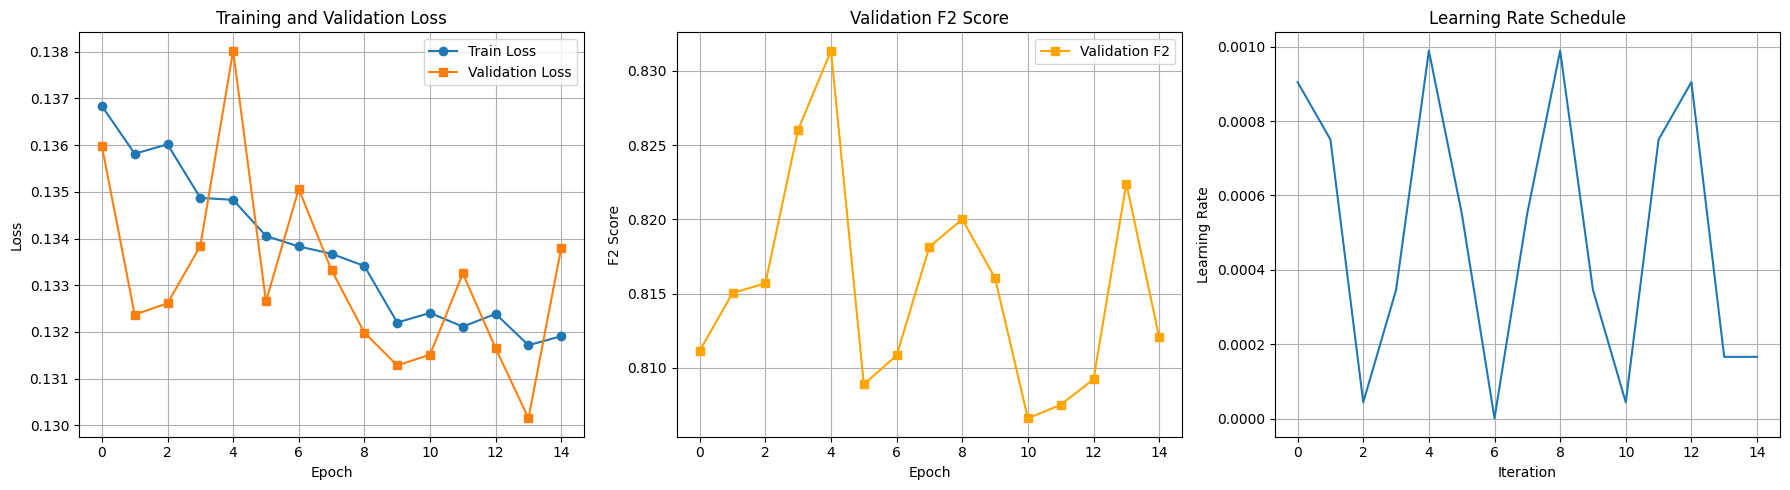


✓ Best F2 Score: 0.8314 at epoch 5


In [ ]:
# Plot training and validation loss + F2
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# F2 Score
axes[1].plot(history['val_f2'], label='Validation F2', marker='s', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F2 Score')
axes[1].set_title('Validation F2 Score')
axes[1].legend()
axes[1].grid(True)

# Learning rate
axes[2].plot(history['learning_rates'])
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].grid(True)

plt.tight_layout()
plt.savefig('training_results.png')
plt.show()

# Print best F2
best_f2 = max(history['val_f2'])
best_epoch = history['val_f2'].index(best_f2) + 1
print(f"\n Best F2 Score: {best_f2:.4f} at epoch {best_epoch}")

La función ejecuta una evaluación completa del modelo en el conjunto de validación y calcula varias métricas centradas en el rendimiento por clase.

Primero, el modelo se pone en modo evaluación y se recorren los batches del DataLoader. Para cada lote, obtiene las salidas del modelo, aplica una sigmoide para convertirlas en probabilidades y luego las umbraliza para generar predicciones binarias. Tanto las predicciones como los valores reales se almacenan y luego se concatenan en arreglos completos.

In [ ]:
# Calculate F2 score and other metrics on validation set
def evaluate_model(model, val_loader, device, threshold=0.5):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            all_targets.append(targets.cpu())
            all_predictions.append(preds.cpu())

    # Concatenate all batches
    all_targets = torch.cat(all_targets)
    all_predictions = torch.cat(all_predictions)

    # Calculate metrics
    from sklearn.metrics import fbeta_score, precision_score, recall_score

    # Convert to numpy for sklearn metrics
    y_true = all_targets.numpy()
    y_pred = all_predictions.numpy()

    # Calculate F2 metrics for each class (beta=2)
    f2_per_class = fbeta_score(y_true, y_pred, beta=2, average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)

    # Calculate micro and macro averages for F2
    f2_micro = fbeta_score(y_true, y_pred, beta=2, average='micro', zero_division=0)
    f2_macro = fbeta_score(y_true, y_pred, beta=2, average='macro', zero_division=0)

    print(f"Micro F2 Score: {f2_micro:.4f}")
    print(f"Macro F2 Score: {f2_macro:.4f}")

    # Return detailed metrics for each class
    return {
        'f2_micro': f2_micro,
        'f2_macro': f2_macro,
        'f2_per_class': f2_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class
    }

## Evalucación por clase
Primero, se llama a evaluate_model, que devuelve todas las métricas calculadas previamente (precisión, recall y F2 por clase, además de los promedios micro y macro). Luego, se genera una gráfica de barras que muestra el F2 por clase, permitiendo ver fácilmente qué etiquetas funcionan bien y cuáles no. Para contextualizar el desempeño general, se añaden dos líneas horizontales: una para el F2 micro y otra para el F2 macro, útiles para comparar cada clase con el rendimiento global.

Después, el código imprime una tabla bien formateada en consola, donde se listan todas las clases junto con su precisión, recall y F2-score. Esto permite identificar, con detalle, clases donde el modelo acierta mucho, clases donde confunde ejemplos, o clases en las que tiene bajo recall pero buena precisión, o viceversa.


Evaluating:   0%|          | 0/253 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 253/253 [00:21<00:00, 11.76it/s]


Micro F2 Score: 0.8314
Macro F2 Score: 0.4783


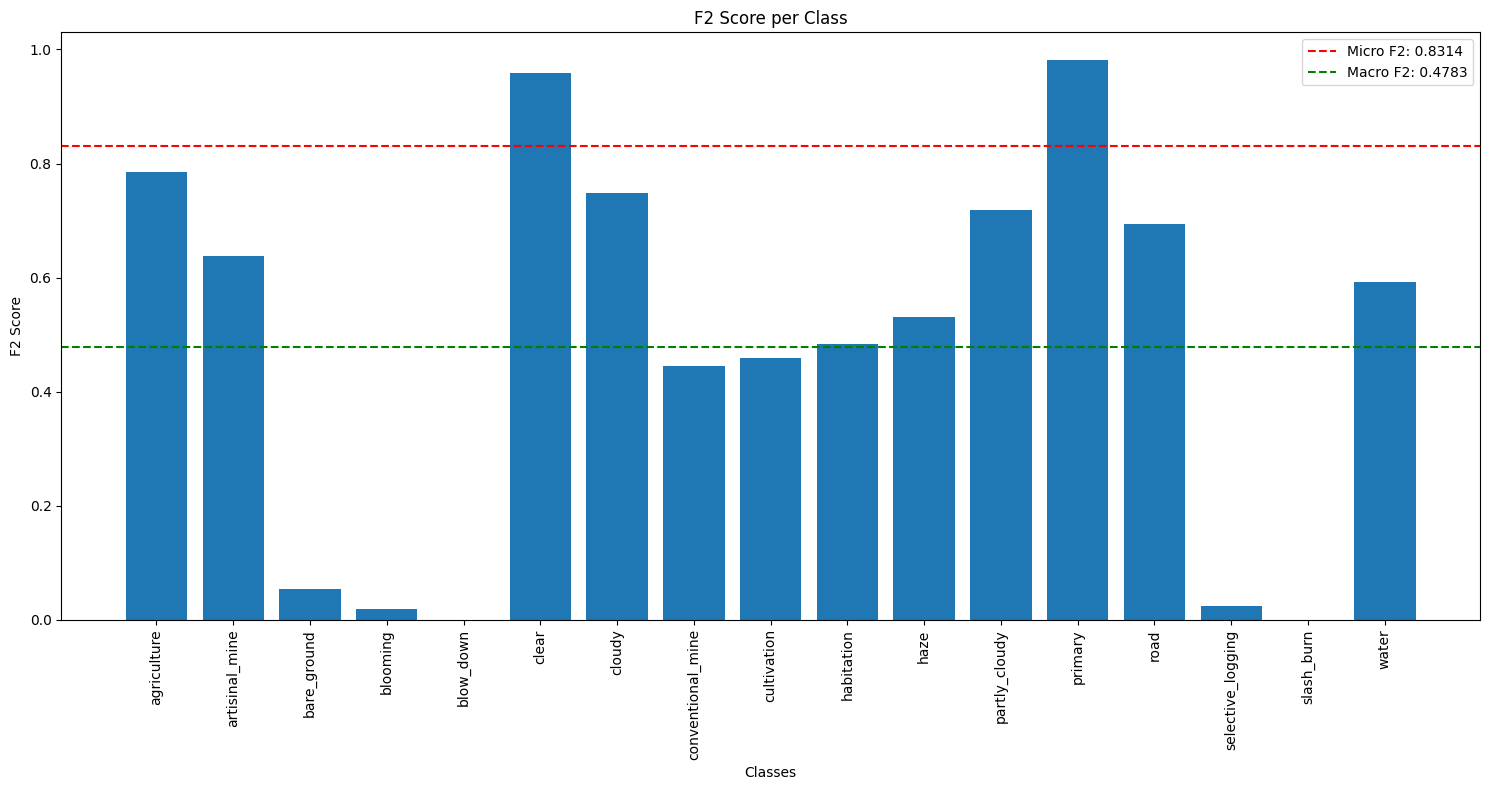


MÉTRICAS POR CLASE
Clase                 Precision     Recall   F2-Score
agriculture              0.7369     0.7981     0.7851
artisinal_mine           0.8393     0.6026     0.6386
bare_ground              0.3810     0.0440     0.0534
blooming                 0.5000     0.0156     0.0194
blow_down                0.0000     0.0000     0.0000
clear                    0.8944     0.9766     0.9590
cloudy                   0.7700     0.7430     0.7482
conventional_mine        0.6923     0.4091     0.4455
cultivation              0.4205     0.4686     0.4581
habitation               0.6981     0.4482     0.4827
haze                     0.7282     0.4965     0.5302
partly_cloudy            0.9113     0.6829     0.7189
primary                  0.9768     0.9821     0.9810
road                     0.7801     0.6758     0.6944
selective_logging        1.0000     0.0192     0.0239
slash_burn               0.0000     0.0000     0.0000
water                    0.7133     0.5686     0.5927
MICRO AV

In [ ]:
# Evaluate the model
metrics = evaluate_model(model, val_loader, device)

# Plot F2 scores for each class
plt.figure(figsize=(15, 8))
plt.bar(range(len(unique_labels)), metrics['f2_per_class'])
plt.xticks(range(len(unique_labels)), unique_labels, rotation=90)
plt.xlabel('Classes')
plt.ylabel('F2 Score')
plt.title('F2 Score per Class')
plt.axhline(y=metrics['f2_micro'], color='r', linestyle='--', label=f"Micro F2: {metrics['f2_micro']:.4f}")
plt.axhline(y=metrics['f2_macro'], color='g', linestyle='--', label=f"Macro F2: {metrics['f2_macro']:.4f}")
plt.legend()
plt.tight_layout()
plt.show()

# Print detailed table
print(f"\n{'='*60}")
print(f"MÉTRICAS POR CLASE")
print(f"{'='*60}")
print(f"{'Clase':<20} {'Precision':>10} {'Recall':>10} {'F2-Score':>10}")
print(f"{'='*60}")
for i, label in enumerate(unique_labels):
    print(f"{label:<20} {metrics['precision_per_class'][i]:>10.4f} {metrics['recall_per_class'][i]:>10.4f} {metrics['f2_per_class'][i]:>10.4f}")
print(f"{'='*60}")
print(f"{'MICRO AVERAGE':<20} {'-':>10} {'-':>10} {metrics['f2_micro']:>10.4f}")
print(f"{'MACRO AVERAGE':<20} {'-':>10} {'-':>10} {metrics['f2_macro']:>10.4f}")
print(f"{'='*60}")

Al analizar las métricas del modelo, se observa que las clases principales siguen siendo las mejor representadas: `[primary, clear, cloudy y partly_cloudy]` mantienen valores de F2 bastante altos, destacándose especialmente primary y clear, que alcanzan niveles prácticamente perfectos. En comparación con los resultados anteriores, estas clases permanecen prácticamente igual, lo cual indica que el modelo conserva un buen entendimiento de las categorías más frecuentes y más fáciles de distinguir visualmente.

En cuanto a clases de frecuencia media, como `[agriculture, road, haze, habitation y cultivation]`, se nota una mejora clara frente a la referencia previa. Por ejemplo, `agriculture` pasa de un F2 cercano a 0.72 a uno de 0.78, y `artisinal_mine`, que antes rondaba un F2 de 0.39, ahora sube significativamente hasta 0.63. Lo mismo ocurre con `cultivation` y `habitation`, donde las mejoras son evidentes. Esto sugiere que el modelo actual está aprendiendo mejor las clases que no son extremadamente frecuentes, pero tampoco son tan raras, probablemente por un entrenamiento más estable o una mejor arquitectura.

Por otro lado, algunas clases como `partly_cloudy` disminuyen un poco su rendimiento respecto a los valores anteriores, aunque siguen siendo decentes. Esto puede deberse a la confusión natural con `cloudy` y `haze`, que visualmente pueden mezclarse fácilmente.

Finalmente, persiste la dificultad extrema en las clases minoritarias como `[blooming, blow_down, selective_logging, slash_burn, conventional_mine]`. En los resultados antiguos ya tenían F2 igual a cero, y en esta evaluación siguen prácticamente igual. Estas clases son muy poco frecuentes y altamente ruidosas, por lo que el modelo no logra aprender patrones consistentes.

En conjunto, el modelo muestra un progreso claro en varias clases intermedias, mantiene un rendimiento sobresaliente en las categorías principales y sigue enfrentando dificultades en las clases más escasas, exactamente como ocurre en la mayoría de trabajos con este dataset.